## Proton Momentum Corrections for the ep$\rightarrow$ep$\pi^0$ exclusive channel

--- 

|Best Value So Far |Hyperparameter |
| -- | -- |
|relu              |act |
|Adam              |opt |
|7                 |layers |
|412               |units |
|0.00096218        |lr |

Best val_loss So Far: 0.3830314874649048

In [1]:
%reset -f
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'
print(tf.config.get_visible_devices())

from tensorflow import keras
from sklearn.metrics import mean_squared_error
from joblib import load

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

np.random.seed(42)
tf.random.set_seed(42)

scaler_X = load('data/scaler_X.joblib')
scaler_y = load('data/scaler_y.joblib')

X_train = np.load('data/X_train_all_feats.npy')
y_train = np.load('data/y_train_all_feats.npy')

X_valid = np.load('data/X_valid_all_feats.npy')
y_valid = np.load('data/y_valid_all_feats.npy')

X_test = np.load('data/X_test_all_feats.npy')
y_test = np.load('data/y_test_all_feats.npy')


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
from sklearn.ensemble import RandomForestRegressor
rnd_reg = RandomForestRegressor(verbose=1, n_jobs=-1)
rnd_reg.fit(X_train, y_train)
y_train_pred, y_valid_pred = rnd_reg.predict(X_train), rnd_reg.predict(X_valid)
# rnd_reg.score(X_train, y_train), rnd_reg.score(X_valid, y_valid)
print("\nTrain MSE:",mean_squared_error(y_train, y_train_pred))
print("Valid MSE:",mean_squared_error(y_valid, y_valid_pred))

X_feats = np.array(["eP", "etheta", "ephi", "pP", "ptheta", "pphi", "log(q2)", "log(t)"])#["ihel", "ex", "ey", "ez", "px", "py", "pz", "g1x", "g1y", "g1z", "g2x", "g2y", "g2z", "idet", "esec", "run", "status"])
importances = rnd_reg.feature_importances_
assert len(X_feats) == len(importances)
idxs = np.argsort(importances)[::-1]
for feat, score in zip(X_feats[idxs], importances[idxs]):
  print(feat, f"{score*100:.3f}%")

# import keras_tuner as kt
# from train import build_model

# tuner = kt.RandomSearch(build_model, objective='val_loss', directory='logs', project_name='diy_space_heater', seed=42)
# model = tuner.get_best_models(num_models=1)[0]

# # model = keras.models.load_model('models/best_model_1.h5')
# # model.summary()
# y_train_pred, y_valid_pred = model(X_train, training=False), model(X_valid, training=False), model(X_test, training=False)
# print("\nTrain MSE:", mean_squared_error(y_train, y_train_pred))
# print("Valid MSE:", mean_squared_error(y_valid, y_valid_pred))
# print("Test MSE:", mean_squared_error(y_test y_test_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s



Train MSE: 0.02789518997522635
Valid MSE: 0.1882427941814272
ptheta 32.815%
log(t) 15.625%
pP 13.587%
log(q2) 9.783%
eP 9.573%
pphi 6.707%
ephi 6.391%
etheta 5.520%


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


In [3]:
# %timeit model.predict(X_train)
# %timeit model(X_train, training=False) # Can be optimized with weight pruning

In [4]:
# eP, eTheta, ePhi, pP, pTheta, pPhi, log(q2), log(t)
X = scaler_X.inverse_transform(X_train)
y = scaler_y.inverse_transform(y_train)
yp = scaler_y.inverse_transform(y_train_pred)

X = scaler_X.inverse_transform(X_train)
y = scaler_y.inverse_transform(y_train)
yp = scaler_y.inverse_transform(y_train_pred)

y[:,0] = np.exp(y[:,0] + X[:,3])
yp[:,0] = np.exp(yp[:,0] + X[:,3])

X[:,0] = np.exp(X[:,0])
X[:,3] = np.exp(X[:,3])

print("MSE:", mean_squared_error(y, yp))

MSE: 0.0001941202243797608


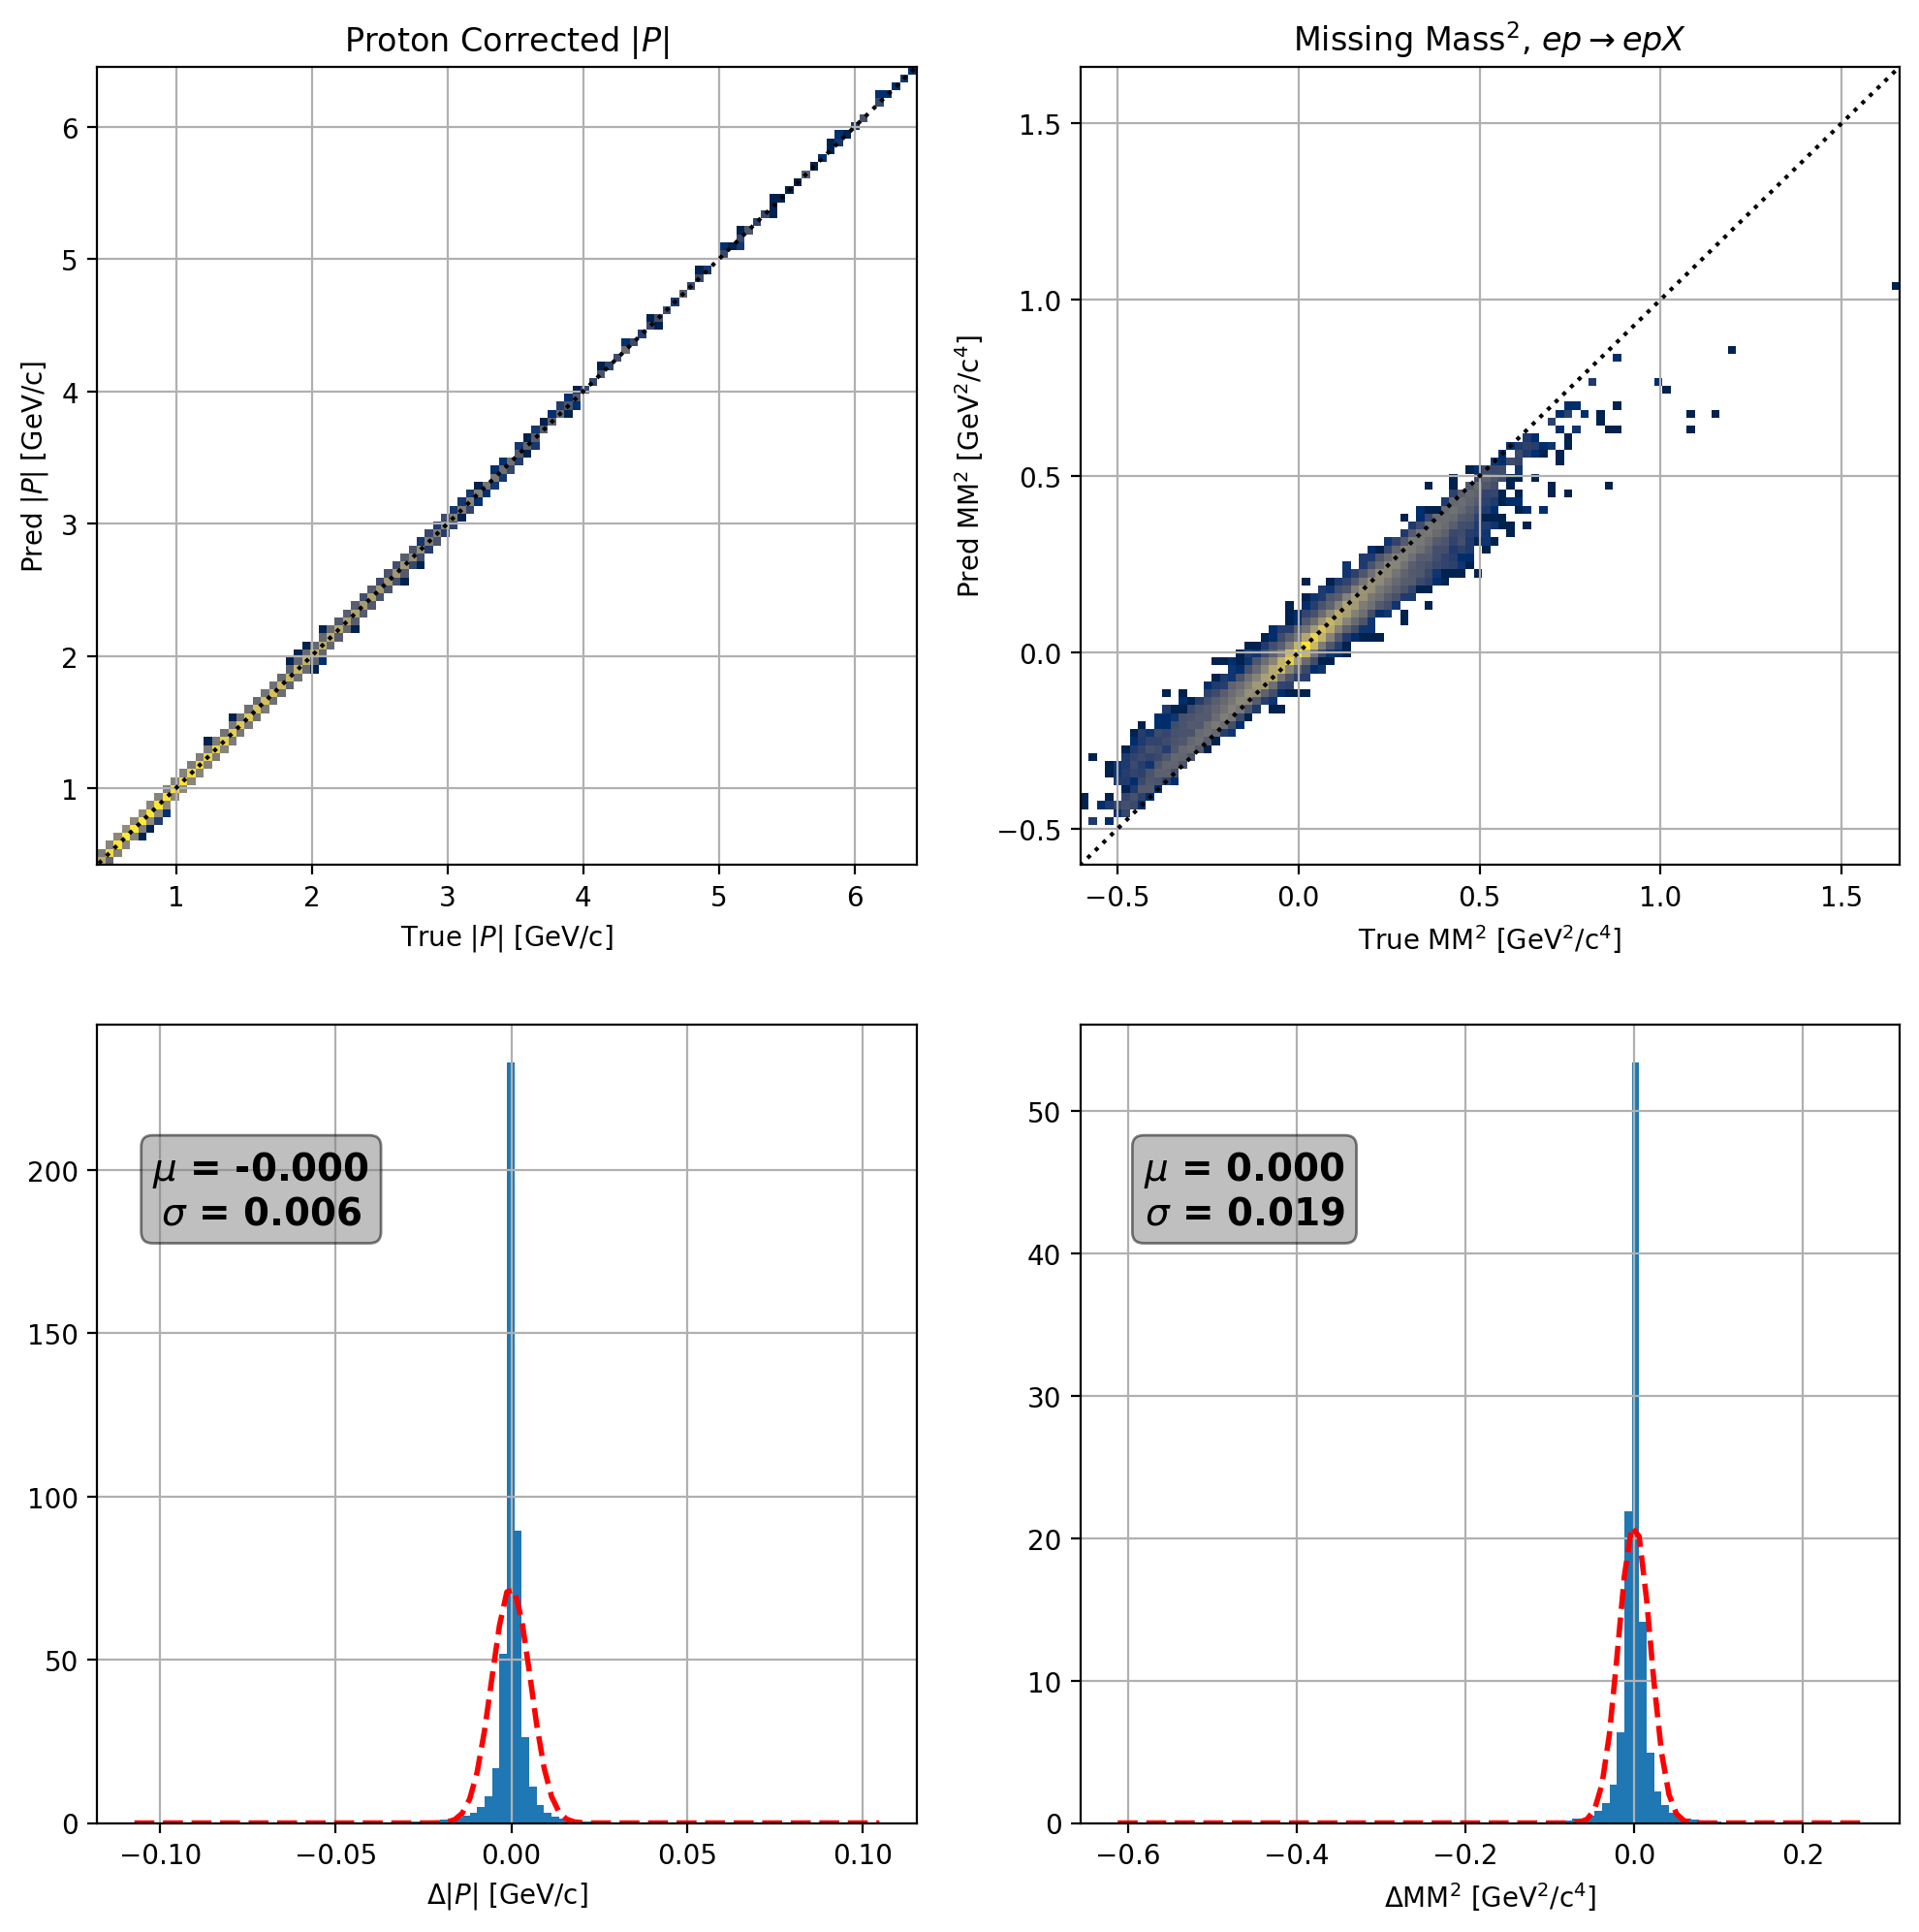

In [5]:
from scipy.stats import norm
f, axs = plt.subplots(2, 2, figsize=(12,12))

xdatas = [y[:,0], y[:,1]]
ydatas = [yp[:,0], yp[:,1]]
titles = [r'Proton Corrected $|P|$', r'Missing Mass$^{2}$, $ep \rightarrow epX$']
xlabs  = [r'True $|P|$ [GeV/c]', r'True MM$^2$ [GeV$^2$/c$^4$]']
ylabs  = [r'Pred $|P|$ [GeV/c]', r'Pred MM$^2$ [GeV$^2$/c$^4$]']


for ax, xd, yd, t, xl, yl in zip(axs.T, xdatas, ydatas, titles, xlabs, ylabs):
  xmin, xmax = np.min(np.c_[xd, yd]), np.max(np.c_[xd, yd])
  ax[0].hist2d(xd, yd, 100, [[xmin,xmax],[xmin,xmax]], cmap='cividis', cmin=1, norm=mpl.colors.LogNorm())
  ax[0].plot([-1e3, 1e3], [-1e3, 1e3], 'k:')
  ax[0].set_title(t)
  ax[0].set_xlabel(xl)
  ax[0].set_ylabel(yl)
  ax[0].grid(True)

  dd = yd - xd
  n, bins, patches = ax[1].hist(dd, density=True, bins=100)
  ax[1].set_xlabel(r'$\Delta$'+xl[5:])
  # ax[1].set_yscale('log')
  ax[1].grid(True)

  (mu, sig) = norm.fit(dd)
  yy = norm.pdf(bins, mu, sig)
  l = ax[1].plot(bins, yy, 'r--', linewidth=2)

  if mu < (bins[-1] + bins[0])/2: xpos=0.8
  else: xpos=0.2
  ax[1].text(xpos, 0.75, f"$\mu$ = {mu:1.3f}\n$\sigma$ = {sig:1.3f}", fontsize=14, fontweight='bold', 
      bbox=dict(facecolor='gray', boxstyle='round', alpha=0.5), ha='center', transform=ax[1].transAxes)


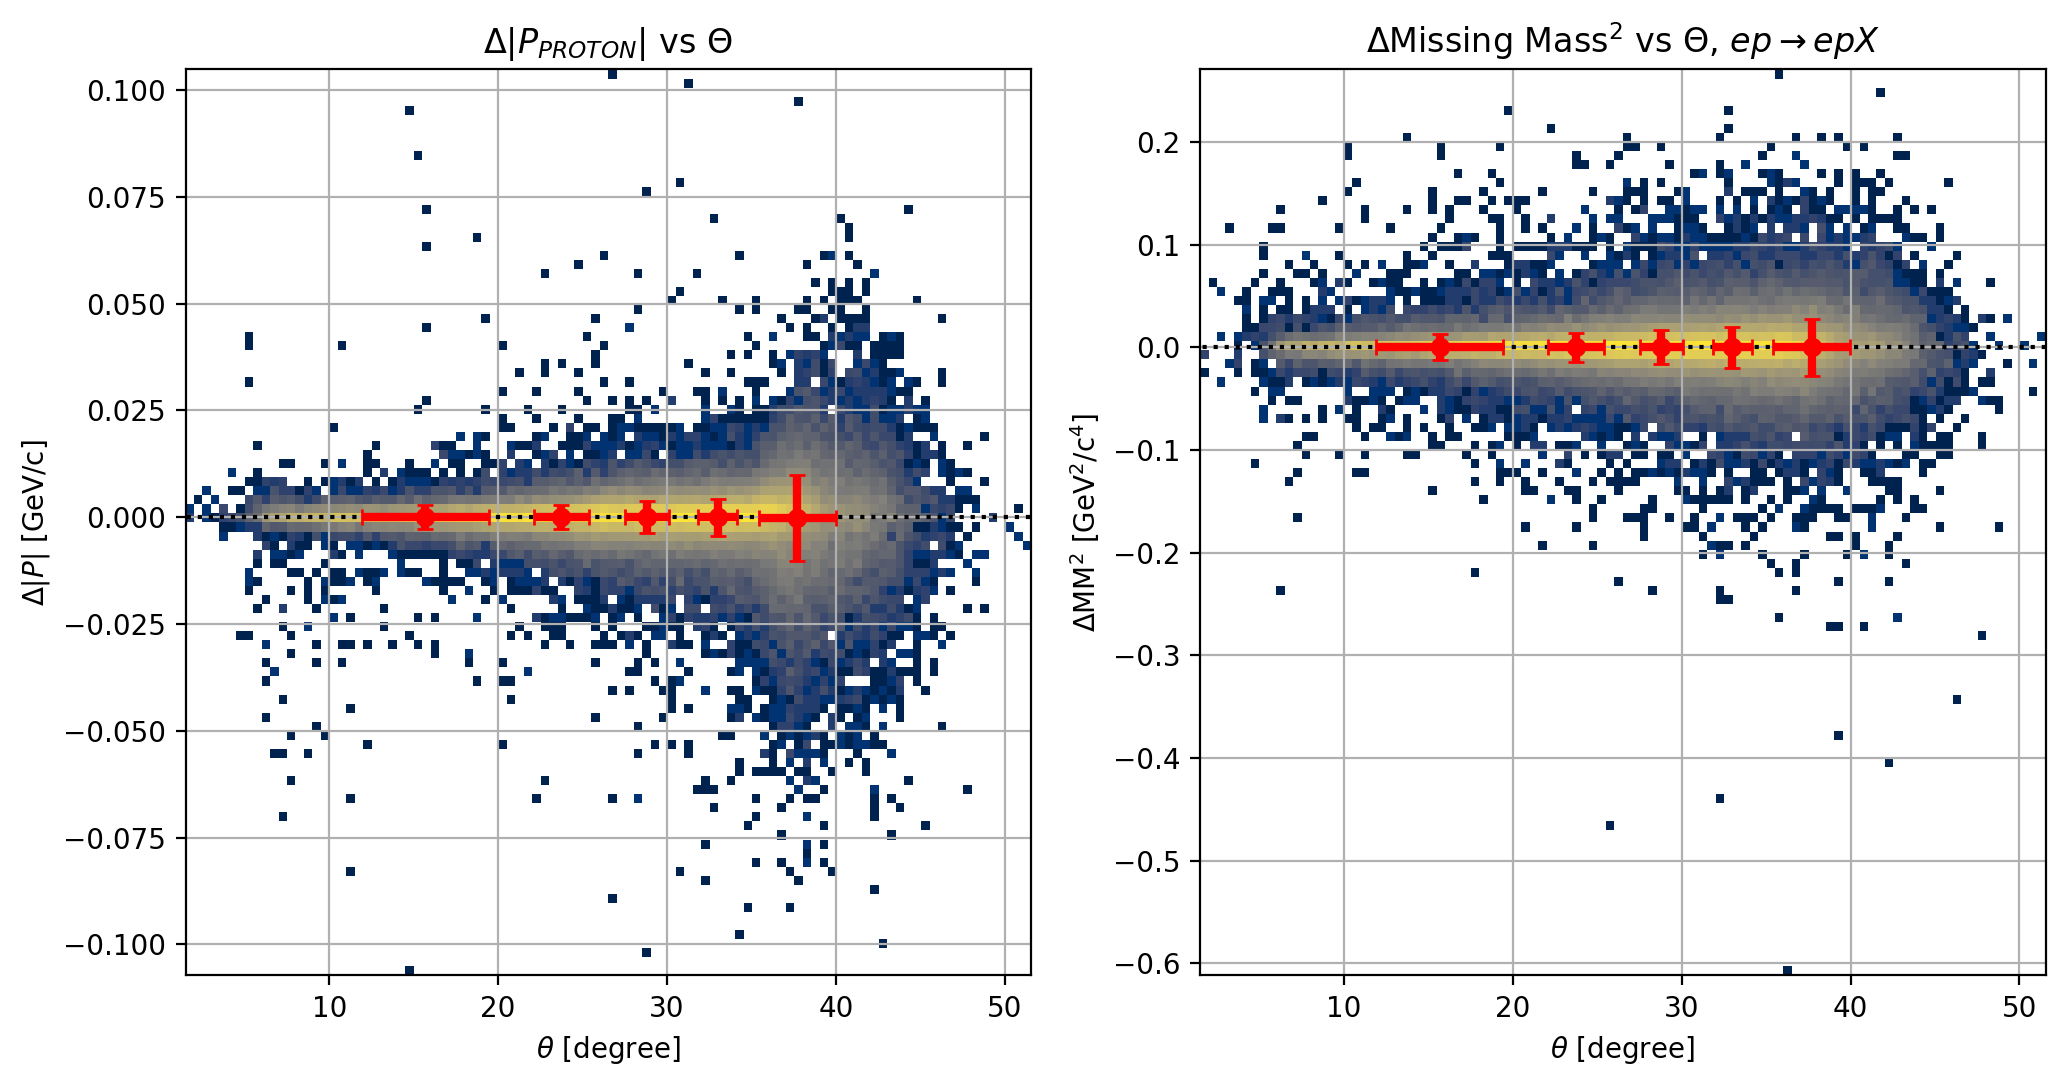

In [6]:
f, axs = plt.subplots(1, 2, figsize=(12,6))

xdatas = 2 * [X[:, 4] * 180/np.pi]
ydatas = [yp[:,i] - y[:,i] for i in range(2)]
titles = [r'$\Delta|P_{PROTON}|$ vs $\Theta$', r'$\Delta$Missing Mass$^{2}$ vs $\Theta$, $ep \rightarrow epX$']
xlabs  = 2 * [r'$\theta$ [degree]']
ylabs  = [r'$\Delta|P|$ [GeV/c]', r'$\Delta$MM$^2$ [GeV$^2$/c$^4$]']

for ax, xd, yd, t, xl, yl in zip(axs, xdatas, ydatas, titles, xlabs, ylabs):
  xmin, xmax = np.min(xd), np.max(xd)
  ymin, ymax = np.min(yd), np.max(yd)
  ax.hist2d(xd, yd, 100, [[xmin,xmax],[ymin,ymax]], cmap='cividis', cmin=1, norm=mpl.colors.LogNorm())
  ax.plot([-1e3, 1e3], [0, 0], 'k:')
  ax.set_title(t)
  ax.set_xlabel(xl)
  ax.set_ylabel(yl)
  ax.grid(True)
  
  bins = np.percentile(xd, np.linspace(0, 100, 5+1))#np.linspace(xmin, xmax, 6+1)
  xx, yy, xerr, yerr = [], [], [], []
  for i in range(len(bins)-1):
    ddx = xd[(bins[i] < xd) & ( xd < bins[i+1])]
    mux, sigx = ddx.mean(), ddx.std()
    ddy = yd[(bins[i] < xd) & ( xd < bins[i+1])]
    muy, sigy = ddy.mean(), ddy.std()
    # (mu, sig) = norm.fit(dd)
    xx.append(mux)#(bins[i+1]+bins[i])/2)
    yy.append(muy)
    xerr.append(sigx)
    yerr.append(sigy)

  ax.errorbar(xx, yy, xerr=xerr, yerr=yerr, c='r', marker='o', ls='none', capsize=3, lw=3)


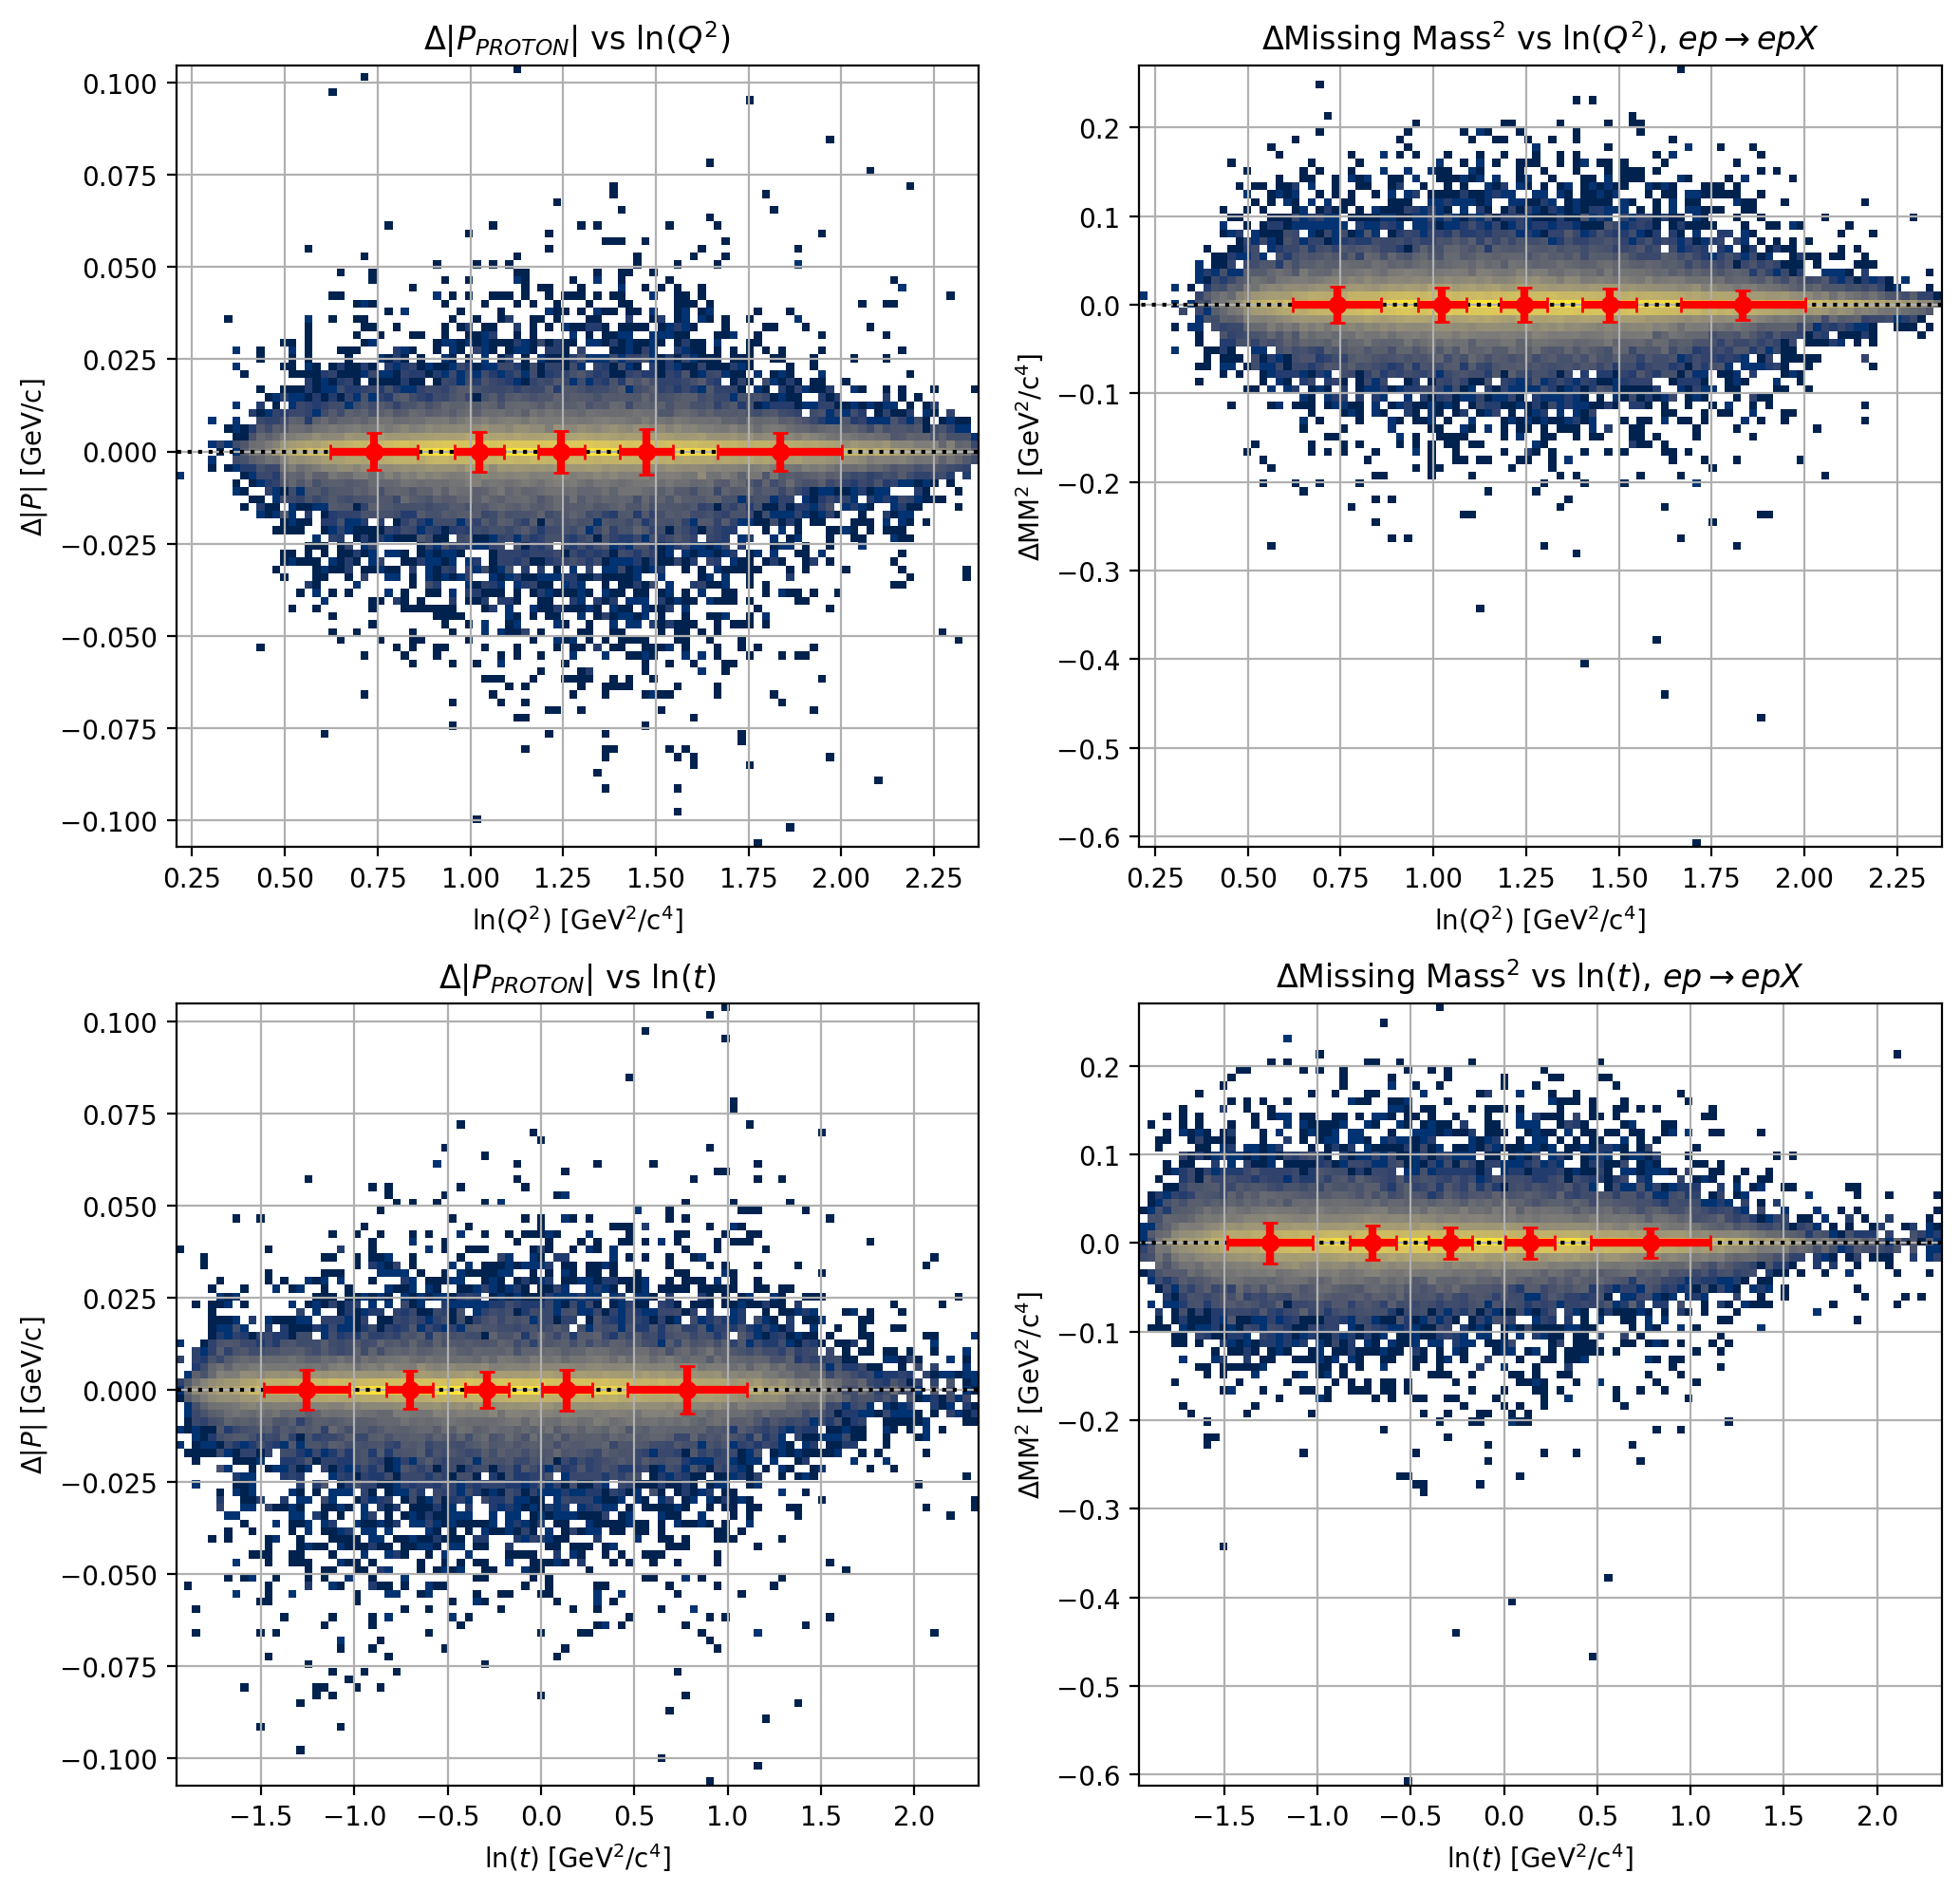

In [7]:
f, axs = plt.subplots(2, 2, figsize=(12,12))
axs = axs.ravel()

# xdatas = 2 * [np.exp(X[:, 6])] + 2 * [np.exp(X[:, 7])]
xdatas = 2 * [X[:, 6]] + 2 * [X[:, 7]]
ydatas = 2 * [yp[:,i] - y[:,i] for i in range(2)]
titles = [r'$\Delta|P_{PROTON}|$ vs ln($Q^2$)', r'$\Delta$Missing Mass$^{2}$ vs ln($Q^2$), $ep \rightarrow epX$']
titles +=[r'$\Delta|P_{PROTON}|$ vs ln($t$)', r'$\Delta$Missing Mass$^{2}$ vs ln($t$), $ep \rightarrow epX$']
xlabs  = 2 * [r'ln($Q^2$) [GeV$^2$/c$^4$]'] + 2 * [r'ln($t$) [GeV$^2$/c$^4$]']
ylabs  = 2 * [r'$\Delta|P|$ [GeV/c]', r'$\Delta$MM$^2$ [GeV$^2$/c$^4$]']

for ax, xd, yd, t, xl, yl in zip(axs, xdatas, ydatas, titles, xlabs, ylabs):
  xmin, xmax = np.min(xd), np.max(xd)
  ymin, ymax = np.min(yd), np.max(yd)
  ax.hist2d(xd, yd, 100, [[xmin,xmax],[ymin,ymax]], cmap='cividis', cmin=1, norm=mpl.colors.LogNorm())
  ax.plot([-1e3, 1e3], [0, 0], 'k:')
  ax.set_title(t)
  ax.set_xlabel(xl)
  ax.set_ylabel(yl)
  ax.grid(True)

  bins = np.percentile(xd, np.linspace(0, 100, 5+1))#np.linspace(xmin, xmax, 6+1)
  xx, yy, xerr, yerr = [], [], [], []
  for i in range(len(bins)-1):
    ddx = xd[(bins[i] < xd) & ( xd < bins[i+1])]
    mux, sigx = ddx.mean(), ddx.std()
    ddy = yd[(bins[i] < xd) & ( xd < bins[i+1])]
    muy, sigy = ddy.mean(), ddy.std()
    # (mu, sig) = norm.fit(dd)
    xx.append(mux)#(bins[i+1]+bins[i])/2)
    yy.append(muy)
    xerr.append(sigx)
    yerr.append(sigy)

  ax.errorbar(xx, yy, xerr=xerr, yerr=yerr, c='r', marker='o', ls='none', capsize=3, lw=3)


X mean: -0.000 +/-  0.006
Y mean: 0.000 +/-  0.019


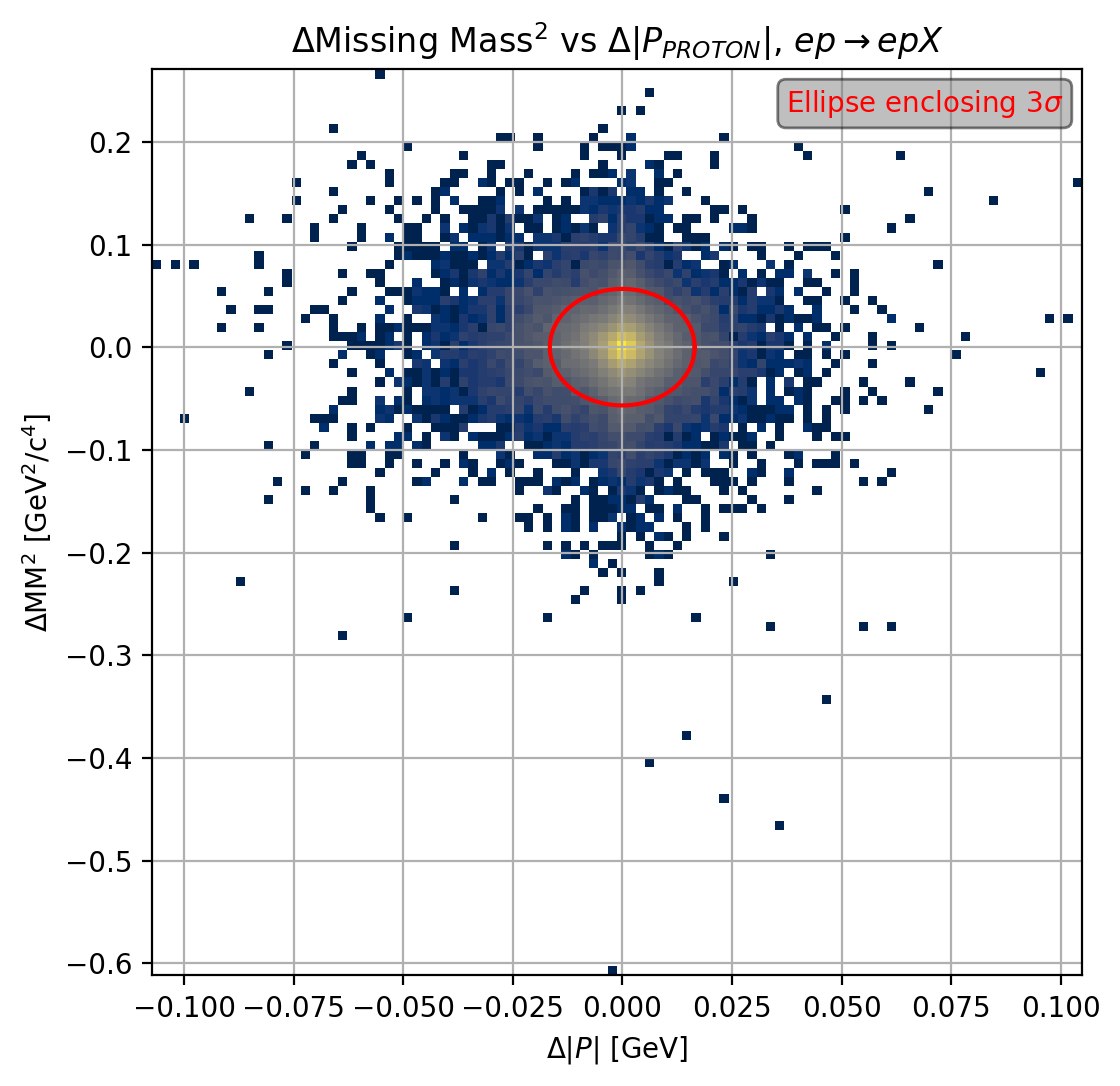

In [8]:
from scipy.interpolate import interp1d
f, axs = plt.subplots(1, 1, figsize=(6,6))

xdatas = [yp[:,0] - y[:,0]]
ydatas = [yp[:,1] - y[:,1]]
titles = [r'$\Delta$Missing Mass$^{2}$ vs $\Delta|P_{PROTON}|$, $ep \rightarrow epX$']
xlabs  = [r'$\Delta|P|$ [GeV]']
ylabs  = [r'$\Delta$MM$^2$ [GeV$^2$/c$^4$]']

for ax, xd, yd, t, xl, yl in zip([axs], xdatas, ydatas, titles, xlabs, ylabs):
  xmin, xmax = np.min(xd), np.max(xd)
  ymin, ymax = np.min(yd), np.max(yd)
  h, xe, ye, img = ax.hist2d(xd, yd, 100, [[xmin,xmax],[ymin,ymax]], cmap='cividis', cmin=1, norm=mpl.colors.LogNorm())
  ax.set_title(t)
  ax.set_xlabel(xl)
  ax.set_ylabel(yl)
  ax.grid(True)
  
  t = np.linspace(0, 2*np.pi, 100)
  xx, yy = 3*xd.std()*np.cos(t) + xd.mean(), 3*yd.std()*np.sin(t) + yd.mean()
  ax.plot(xx, yy, c='r')

  ax.text(0.98, 0.98, f"Ellipse enclosing 3$\sigma$", fontsize=10, c='r',
    bbox=dict(facecolor='gray', boxstyle='round', alpha=0.5), va='top', ha='right', transform=ax.transAxes)


  # hh = h / h.sum()
  # t = np.linspace(0, hh.max(), 1000)
  # integral = ((hh >= t[:, None, None]) * hh).sum(axis=(1,2))
  # conts = interp1d(integral, t)([0.99, 0.9])
  # ax.contour(hh.T, extent=[xe.min(), xe.max(), ye.min(), ye.max()], levels=conts, cmap='autumn')

  print(f"X mean: {xd.mean():.3f} +/-  {xd.std():.3f}")
  print(f"Y mean: {yd.mean():.3f} +/-  {yd.std():.3f}")
